In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
N = 100
L = 1000
T = 20
X = np.empty((N, L), np.float32)
X[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
Y = np.sin(X / 1.0 / T).astype(np.float32)

plt.figure(figsize=(10, 8))
plt.title("Sine Wave")
plt.xlabel("X")
plt.ylabel("Y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Plotting the first row of Y against the index
plt.plot(np.arange(Y.shape[1]), Y[0, :], "r")

plt.show()

In [ ]:
class LSTMPredictor(nn.Module):
  def __init__(self, n_hidden=51):
    super(LSTMPredictor, self).__init__()
    self.n_hidden = n_hidden
    # lstm1, lstm2, linear
    self.lstm1 = nn.LSTMCell(1, self.n_hidden)# We go over sin values one by one
    self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
    self.linear = nn.Linear(self.n_hidden,1)


  def forward(self,X, future=0): # we want to predict the next number of future value
    # future = 0 : training, not prediction
    outputs = []
    n_samples = X.size(0)
    h_t = torch.zeros(n_samples, self.n_hidden, dtype= torch.float32) # initial hidden state
    c_t = torch.zeros(n_samples, self.n_hidden, dtype= torch.float32) # initial cell state
    h_t2 = torch.zeros(n_samples, self.n_hidden, dtype= torch.float32)
    c_t2 = torch.zeros(n_samples, self.n_hidden, dtype= torch.float32)

    # this split the tensor into chunks and each chunk is a view of the original tensor
    for input_t in X.split(1, dim=1):
      #N, 1
      h_t, c_t = self.lstm1(input_t,(h_t, c_t))
      h_t2, c_t2 = self.lstm2(h_t,(h_t2, c_t2))
      output = self.linear(h_t2)
      outputs.append(output)

    for i in range (future):
      h_t, c_t = self.lstm1(output,(h_t, c_t))
      h_t2, c_t2 = self.lstm2(h_t,(h_t2, c_t2))
      output = self.linear(h_t2)
      outputs.append(output)

    outputs = torch.cat(outputs, dim=1)
    return outputs





Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
loss 0.5101629495620728
loss 0.5054194331169128
loss 0.491366982460022
loss 0.4776400923728943
loss 0.4326486587524414
loss 0.2434687465429306
loss 0.06530289351940155
loss 0.03372960910201073
loss 0.11577095091342926
loss 0.020125452429056168
loss 0.01914849504828453
loss 0.01887042261660099
loss 0.018704809248447418
loss 0.018300173804163933
loss 0.017426669597625732
loss 0.01563822664320469
loss 0.012369543313980103
loss 0.007103137206286192
loss 0.01802847906947136
loss 0.0018201874336227775
test loss 0.0014602644369006157


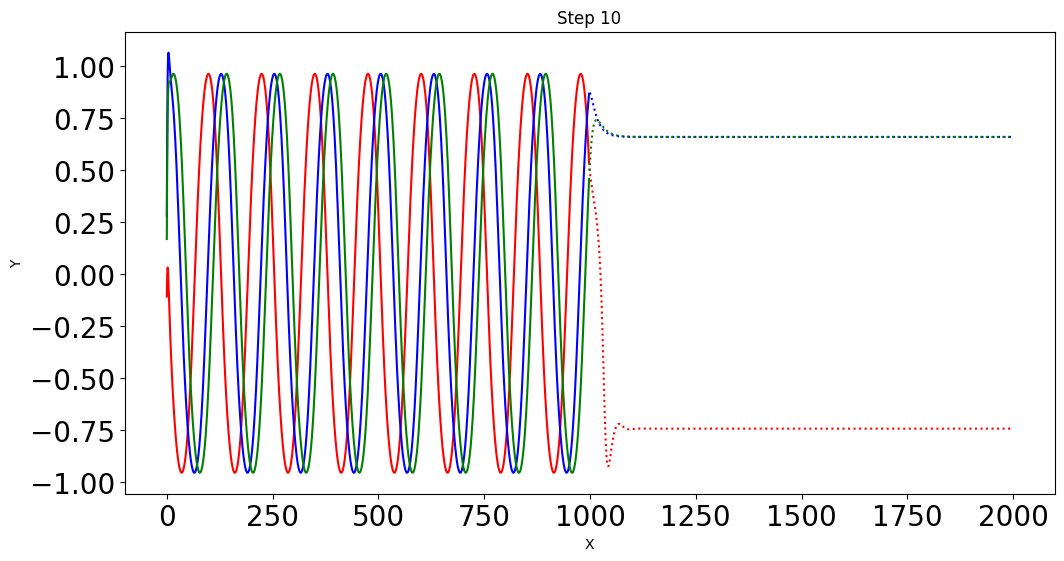

In [ ]:

# Y = 100, 1000
train_input = torch.from_numpy(Y[3:, :-1]) # 97, 999
train_target = torch.from_numpy(Y[3:, 1:]) # 97, 999
test_input = torch.from_numpy(Y[:3, :-1]) # 3, 999
test_target = torch.from_numpy(Y[:3, 1:]) #3,999

model = LSTMPredictor()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr= 0.8) #LBFGS needs a function as input: closure

n_steps = 10
for i in range(n_steps):
  print("Step", i)

def closure():
  optimizer.zero_grad()
  out = model(train_input)
  loss = criterion(out, train_target)
  print("loss", loss.item())
  loss.backward()
  return loss
optimizer.step(closure)

with torch.no_grad():
  pred = model(test_input)
  future = 1000
  pred = model(test_input, future= future)
  loss = criterion(pred[:,: - future], test_target)
  print("test loss", loss.item())
  Y = pred.detach().numpy()

  plt.figure(figsize=(12, 6))
  plt.title(f"Step {i+1}")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  n = train_input.shape[1] # 999
  def draw(Y_i, color):
      plt.plot(np.arange(n), Y_i[:n], color)
      plt.plot(np.arange(n, n+future), Y_i[n:], color+":")

  draw(Y[0],"r")
  draw(Y[1],"b")
  draw(Y[2],"g")
  plt.savefig("predict%d.pdf"%i)
  plt.close


